## Question Answering with a fine-tuned BERT on CoQA dataset

### Importing the libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pip install transformers

import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import warnings
warnings.filterwarnings('ignore')


### Loading the data

In [38]:
data = pd.read_excel("oneamz_q_ans_reviewed.xlsx")
data.head()

,Questions,Answers
0,Subscription Cancellation - Seller Account Dow...,Your OneAMZ membership is service-based and th...
1,ACM 24 hours,I have forwarded your request to your dedicate...
2,What is Acm ?,"By expanding the scope of our ""Free Account Ma..."
3,You can get assistance from your Account Manag...,"Hello, you can get assistance from your Accoun..."
4,My Buyer Account was Suspended. How Do I Defin...,Opening your new buyer account on a different ...


In [39]:
print("Number of question and answers: ", len(data))

Number of question and answers:  103


### Building the chatbot

In [4]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
random_num = np.random.randint(0,len(data))

question = data["Questions  "][random_num]
text = data["Answers"][random_num]

In [41]:
print(question, "\n", text)

How to Convert a Store from Individual to Professional? 
 1. To switch to an Individual plan, you can go to Seller account - Account info - Your Services Manage - Downgrade (you must click 'proceed to downgrade' again).
2. To switch to a Professional plan, you can go to Seller account - Account info - Your Services Manage - Upgrade.


In [42]:
input_ids = tokenizer.encode(question, text)
print("The input has a total of {} tokens.".format(len(input_ids)))

The input has a total of 76 tokens.


In [43]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):
    print('{:8}{:8,}'.format(token,id))

[CLS]        101
how        2,129
to         2,000
convert   10,463
a          1,037
store      3,573
from       2,013
individual   3,265
to         2,000
professional   2,658
?          1,029
[SEP]        102
1          1,015
.          1,012
to         2,000
switch     6,942
to         2,000
an         2,019
individual   3,265
plan       2,933
,          1,010
you        2,017
can        2,064
go         2,175
to         2,000
seller    14,939
account    4,070
-          1,011
account    4,070
info      18,558
-          1,011
your       2,115
services   2,578
manage     6,133
-          1,011
down       2,091
##grade   24,170
(          1,006
you        2,017
must       2,442
click     11,562
'          1,005
proceed   10,838
to         2,000
down       2,091
##grade   24,170
'          1,005
again      2,153
)          1,007
.          1,012
2          1,016
.          1,012
to         2,000
switch     6,942
to         2,000
a          1,037
professional   2,658
plan       2,933
, 

In [44]:
#first occurence of [SEP] token
sep_idx = input_ids.index(tokenizer.sep_token_id)
print(sep_idx)

#number of tokens in segment A - question
num_seg_a = sep_idx+1
print(num_seg_a)

#number of tokens in segment B - text
num_seg_b = len(input_ids) - num_seg_a
print(num_seg_b)

segment_ids = [0]*num_seg_a + [1]*num_seg_b
print(segment_ids)

assert len(segment_ids) == len(input_ids)

11
12
64
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [45]:
#token input_ids to represent the input
#token segment_ids to differentiate our segments - text and question 
output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
#print(output.start_logits, output.end_logits)

In [46]:
#tokens with highest start and end scores
answer_start = torch.argmax(output.start_logits)
answer_end = torch.argmax(output.end_logits)
#print(answer_start, answer_end)

In [47]:
if answer_end >= answer_start:
    answer = " ".join(tokens[answer_start:answer_end+1])
else:
    print("I am unable to find the answer to this question. Can you please ask another question?")
    
print("Text:\n{}".format(text.capitalize()))
print("\nQuestion:\n{}".format(question.capitalize()))
print("\nAnswer:\n{}.".format(answer.capitalize()))

Text:
1. to switch to an individual plan, you can go to seller account - account info - your services manage - downgrade (you must click 'proceed to downgrade' again).
2. to switch to a professional plan, you can go to seller account - account info - your services manage - upgrade.

Question:
How to convert a store from individual to professional?

Answer:
You must click ' proceed to down ##grade ' again ) . 2 . to switch to a professional plan , you can go to seller account - account info - your services manage - upgrade.


### Visualization of the tokens

In [13]:
start_scores = output.start_logits.detach().numpy().flatten()
end_scores = output.end_logits.detach().numpy().flatten()

token_labels = []
for i, token in enumerate(tokens):
    token_labels.append("{}-{}".format(token,i))

In [14]:
print(len(token_labels))

76


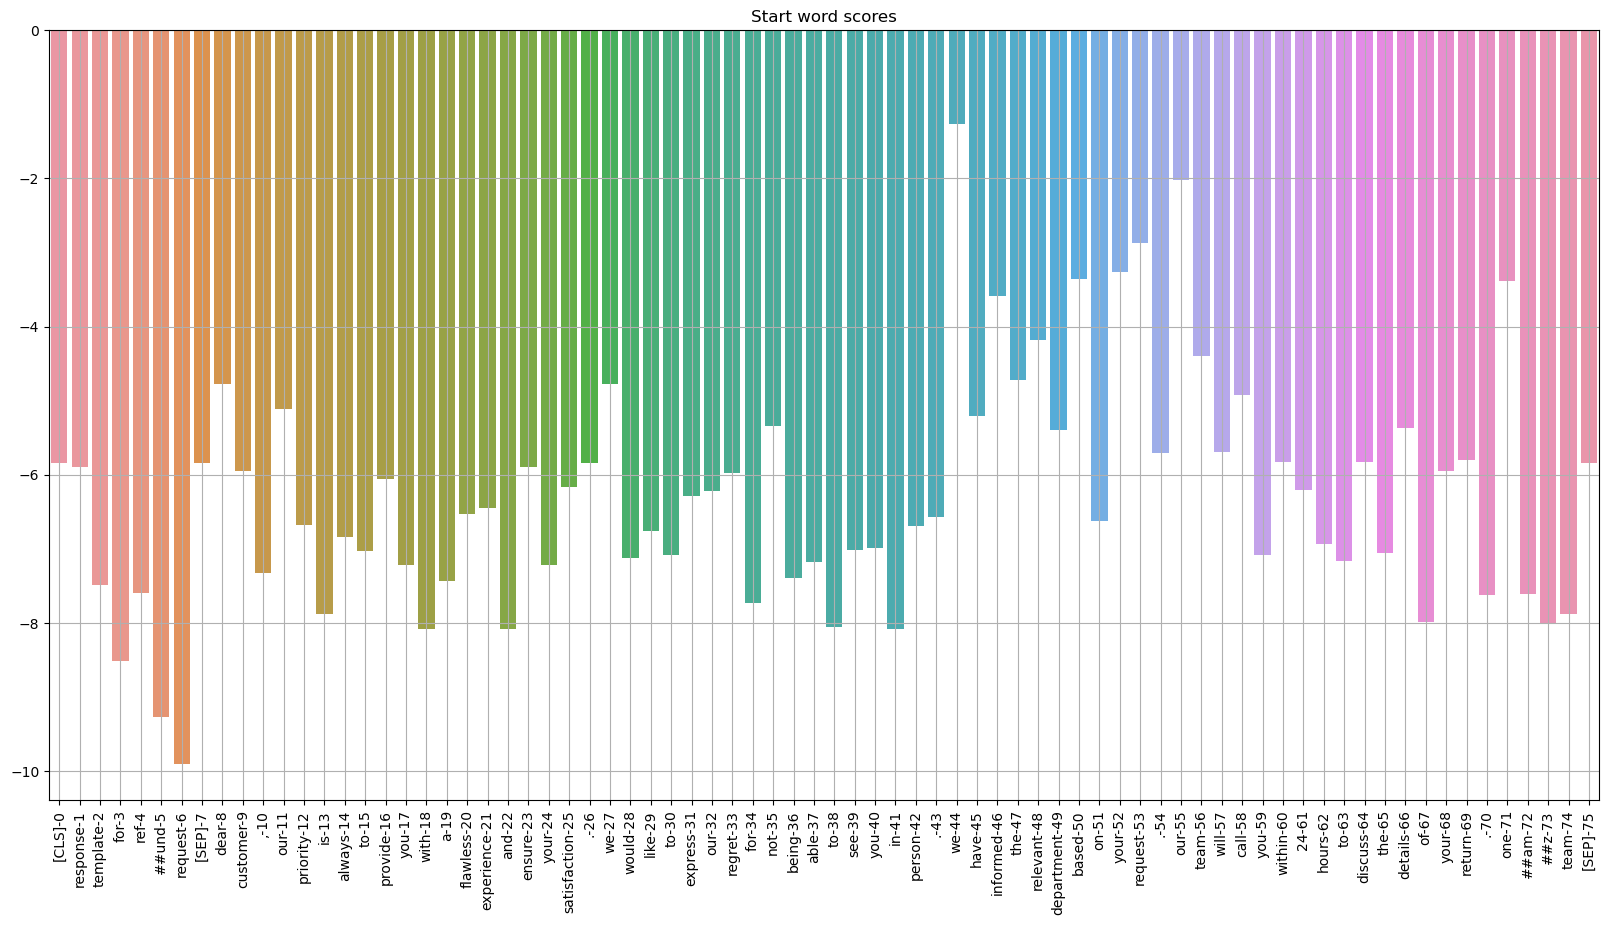

In [15]:
#first 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[:80], y=start_scores[:80], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start word scores")
plt.show()

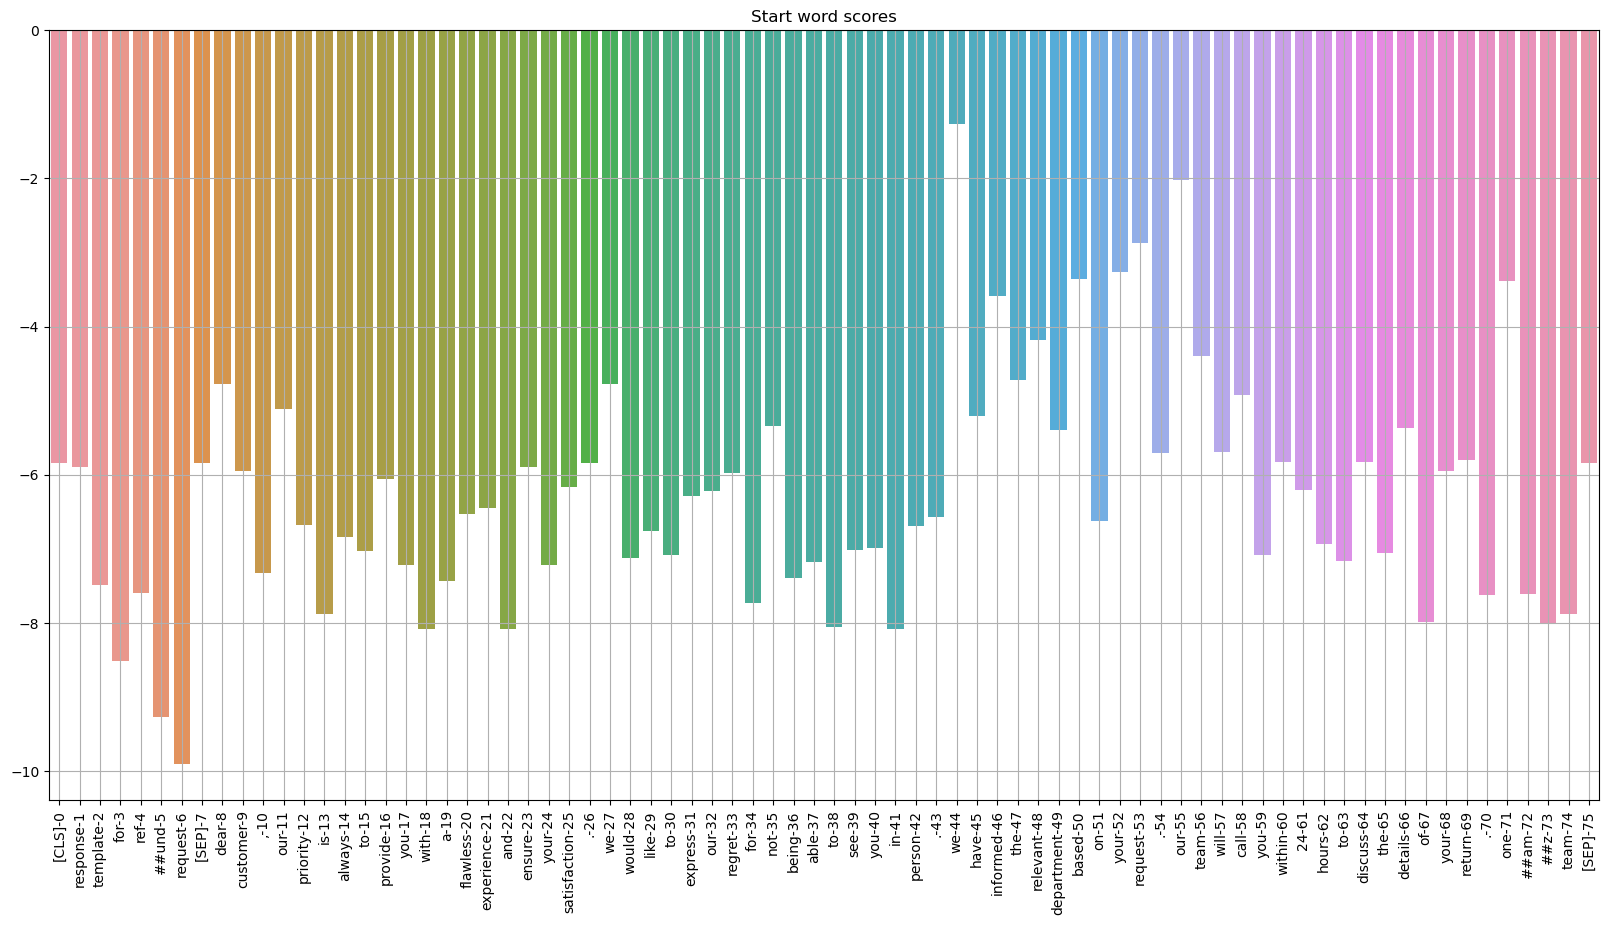

In [16]:
#last 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[-80:], y=start_scores[-80:], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start word scores")
plt.show()

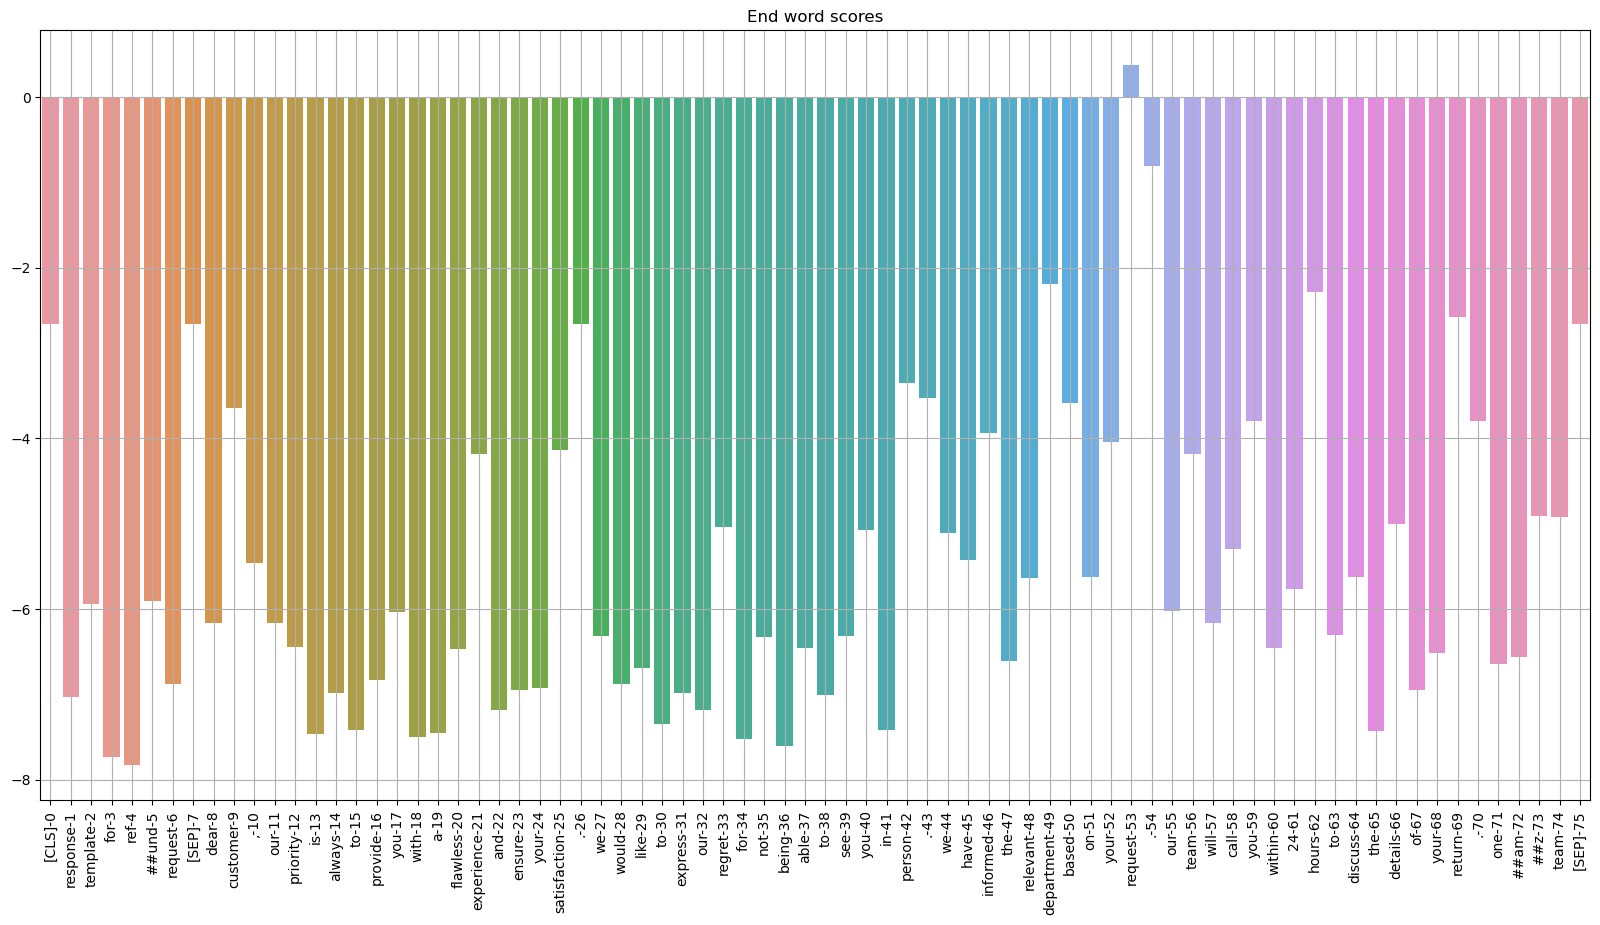

In [17]:
#first 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[:80], y=end_scores[:80], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End word scores")
plt.show()

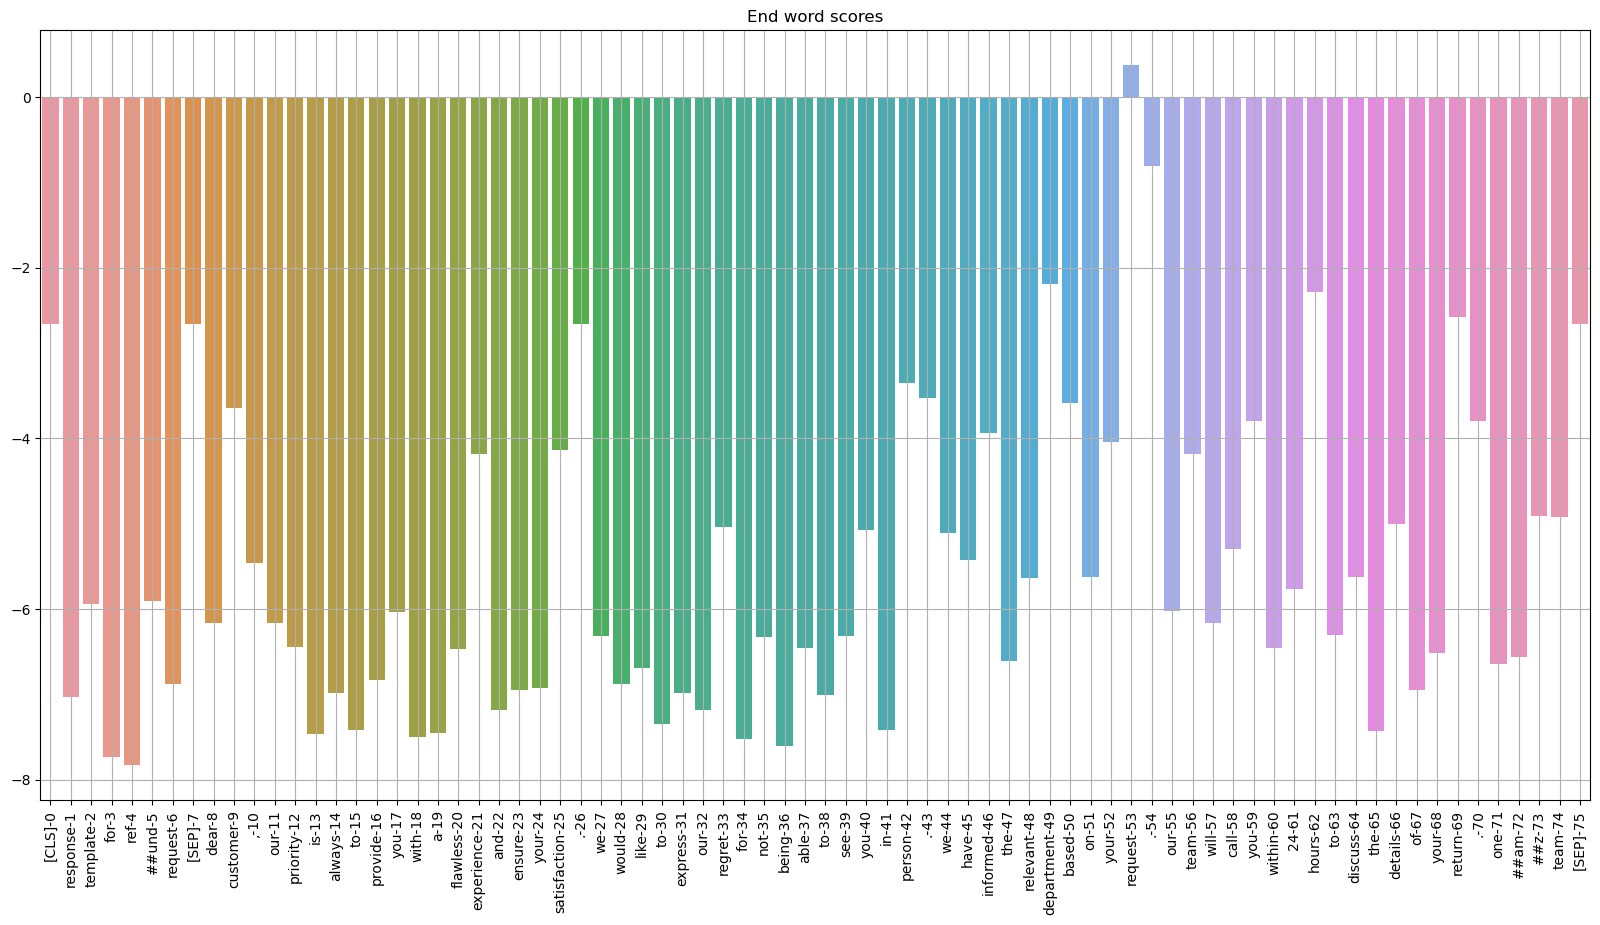

In [18]:
#last 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[-80:], y=end_scores[-80:], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End word scores")
plt.show()

### Code to join the broken words

In [19]:
answer = tokens[answer_start]

for i in range(answer_start+1, answer_end+1):
    if tokens[i][0:2] == "##":
        answer += tokens[i][2:]
    else:
        answer += " " + tokens[i]

### Function

In [20]:
def question_answer(question, text):
    
    #tokenize question and text in ids as a pair
    input_ids = tokenizer.encode(question, text)
    
    #string version of tokenized ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    #segment IDs
    #first occurence of [SEP] token
    sep_idx = input_ids.index(tokenizer.sep_token_id)

    #number of tokens in segment A - question
    num_seg_a = sep_idx+1

    #number of tokens in segment B - text
    num_seg_b = len(input_ids) - num_seg_a
    
    #list of 0s and 1s
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    assert len(segment_ids) == len(input_ids)
    
    #model output using input_ids and segment_ids
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
    #reconstructing the answer
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)

    if answer_end >= answer_start:
        answer = tokens[answer_start]
        for i in range(answer_start+1, answer_end+1):
            if tokens[i][0:2] == "##":
                answer += tokens[i][2:]
            else:
                answer += " " + tokens[i]
                
    if answer.startswith("[CLS]"):
        answer = "Unable to find the answer to your question."
    
#     print("Text:\n{}".format(text.capitalize()))
#     print("\nQuestion:\n{}".format(question.capitalize()))
    print("\nAnswer:\n{}".format(answer.capitalize()))

In [48]:
text = """ If you attempt to add a product from your Product Bot pool without the product being present, you will encounter an error stating 'selected product not found.' If you have conducted a product scan and are unable to add pending products, you can check the validity of the seller token in the 'REFRESH TOKEN' section under the Settings tab. If it's invalid, you can renew it using the adjacent button."""
question= 'how can I  Add a Product to Amazon?'
question_answer(question, text)


Answer:
From your product bot pool without the product being present


In [49]:
print("Original answer:\n", data.loc[data['Questions  '] == question]['Answers'].values[0])


IndexError: index 0 is out of bounds for axis 0 with size 0

In [31]:
result = data.loc[data['Questions  '] == question]['Answers']
if not result.empty:
    print("Original answer:\n", result.values[0])
else:
    print("No answer found for the given question.")


No answer found for the given question.


In [32]:
data.columns.to_list()

['Questions  ', 'Answers']

### Playing with the chatbot

In [50]:
text = input("Please enter your text: \n")
question = input("\nPlease enter your question: \n")

while True:
    question_answer(question, text)
    
    flag = True
    flag_N = False
    
    while flag:
        response = input("\nDo you want to ask another question based on this text (Y/N)? ")
        if response[0] == "Y":
            question = input("\nPlease enter your question: \n")
            flag = False
        elif response[0] == "N":
            print("\nBye!")
            flag = False
            flag_N = True
            
    if flag_N == True:
        break

Please enter your text: 
If your product is in an inactive status due to reasons like running out of stock, you won't be visible among sellers. You can check this situation by searching for the relevant product in OneAMZ Inventory. If your product appears as active, you can check your store among sellers on the Amazon site of your target country, not Amazon.com. When looking at the list of sellers in the target store, don't forget to change the "Deliver to" section at the top left with a postal code from the target country.

Please enter your question: 
What is inactive status

Answer:
Running out of stock

Do you want to ask another question based on this text (Y/N)? Y

Please enter your question: 
where is relevant product

Answer:
Oneamz inventory

Do you want to ask another question based on this text (Y/N)? Y

Please enter your question: 
What I need to remember

Answer:
If your product is in an inactive status due to reasons like running out of stock , you won ' t be visible amon

### Version checking

In [34]:
torch.__version__

'2.1.2'

In [35]:
# Modeli kaydedin
model_save_path = 'model_name'
model.save_pretrained(model_save_path)


In [36]:
import transformers
import torch

print("Transformers version:", transformers.__version__)
print("PyTorch version:", torch.__version__)


Transformers version: 4.32.1
PyTorch version: 2.1.2
